## Imports

In this section, we'll import:
- `json` to parse the JSON documents
- `wordcloud` for the creation of a word cloud
- `matplotlib` to show the word cloud
- `lookup_json` (local) to allow the extraction of all lyrics from the tracks 

In [2]:
import os
import json
import re

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

import lookup_json

## Read the text

In [3]:
with open(os.curdir + "/../data/backup-tracks.json", 'r') as f:
    obj = json.load(f)

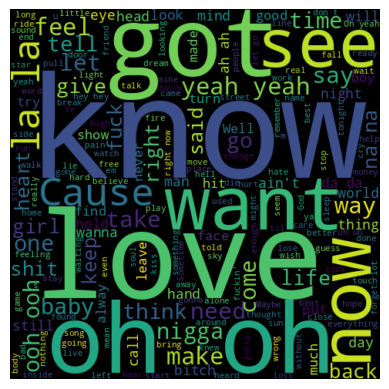

In [35]:
text = " ".join(lookup_json.dump(obj, ["*", "lyrics", "*", "content"]))

# Create the wordcloud object
wordcloud = WordCloud(width=480, height=480, margin=0).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

## Descriptive Statistics

In [4]:
def get_present_values(obj, path):
    missing = []
    
    values = list(lookup_json.dump(obj, path, missing))
    present_values = list(filter(lambda x: x is not missing, values))
    
    return (present_values, values)

def print_missing(obj, path, name):
    present_values, values = get_present_values(obj, path)
    print(f"Missing {name} (%): {100 - (100 * len(present_values) / len(values))}")
    

In [14]:
print_missing(obj, ["*", "publishedAt"], "publishedAt")
print_missing(obj, ["*", "album"], "album")
print_missing(obj, ["*", "album", "image"], "album.image")
print_missing(obj, ["*", "lyrics", "0", "title"], "lyrics.0.title")
print_missing(obj, ["*", "duration"], "duration")
print_missing(obj, ["*", "publishedAt"], "publishedAt")

df_durations = pd.DataFrame(get_present_values(obj, ["*", "duration"])[0], columns=["duration"])
df_durations.describe()

Missing publishedAt (%): 68.26660988074957
Missing album (%): 8.801107325383299
Missing album.image (%): 3.3343451560931214
Missing lyrics.0.title (%): 12.787478705281089
Missing duration (%): 20.664395229982958
Missing publishedAt (%): 68.26660988074957


,duration
count,3.725600e+04
mean,2.181634e+05
std,7.845663e+04
min,3.000000e+03
25%,1.780000e+05
50%,2.110000e+05
75%,2.480000e+05
max,3.922000e+06


In [5]:
wc_regex = re.compile(r"\b\S+\b")

def get_words(text):
    yield from map(lambda x: x.group(), wc_regex.finditer(text))

In [34]:

word_counts = []
section_counts = []

weird_songs = []
for index, lyrics in enumerate(lookup_json.dump(obj, ["*", "lyrics"])):
    sections = list(lookup_json.dump(lyrics, ["*", "content"]))
    
    text = "\n".join(sections)
    num_words = len(list(get_words(text)))
    if num_words == 0:
        weird_songs.append(lookup_json.dump(obj, [str(index), "lyrics"]).__next__())
    
    section_counts.append(len(sections))
    word_counts.append(num_words)
    
print(weird_songs)
    
df_word_counts = pd.DataFrame(word_counts, columns=["word_count"])
df_word_counts.describe()

df_section_counts = pd.DataFrame(section_counts, columns=["section_count"])
df_section_counts.describe()

[[{'content': '...'}], [{'title': '久石譲「あの夏へ」歌詞', 'content': ''}, {'title': 'Instrumental', 'content': ''}], [{'title': 'Instrumental', 'content': ''}, {'title': 'Part 1. Something Else – 0:00-3:57', 'content': ''}, {'title': 'Part 2. Syncopated Pandemonium – 3:57-7:04', 'content': ''}, {'title': 'Part 3. Storm Signal – 7:04-8:38', 'content': ''}], [{'title': 'Instrumental', 'content': ''}, {'title': 'Part 1. Something Else – 0:00-3:57', 'content': ''}, {'title': 'Part 2. Syncopated Pandemonium – 3:57-7:04', 'content': ''}, {'title': 'Part 3. Storm Signal – 7:04-8:38', 'content': ''}], [{'title': 'Instrumental', 'content': ''}], [{'title': 'Cedric walks up the stairs, goes into the house & shuts the door', 'content': ''}], [{'title': 'Instrumental', 'content': ''}], [{'content': '\u200e'}], [{'title': 'Produced by RandomBlackDude', 'content': ''}], [{'title': 'Produced by Nujabes', 'content': ''}], [{'title': 'Instrumental', 'content': ''}], [{'title': 'Full Title: To the Workers of the

,section_count
count,46960.000000
mean,6.649915
std,3.876082
min,1.000000
25%,5.000000
50%,7.000000
75%,9.000000
max,100.000000


In [51]:
genre_counts = {}
for genre in lookup_json.dump(obj, ["*", "genres", "*"]):
    if genre in genre_counts:
        genre_counts[genre] += 1
    else:
        genre_counts[genre] = 1
 
       
genre_items = list(sorted(genre_counts.items(), key=lambda x: x[1], reverse=True))
df_tag_counts = pd.DataFrame(genre_items, columns=["tag", "count"])
df_tag_counts.describe()

# df_tag_counts.plot.bar(x="tag", y="count")
df_tag_counts.head(20)


,tag,count
0,rock,9081
1,hip-hop,3950
2,rap,3481
3,female vocalists,3402
4,alternative rock,2883
5,hip hop,2665
6,soul,1990
7,indie rock,1867
8,indie pop,1187
9,hard rock,1106


<Axes: xlabel='Year'>

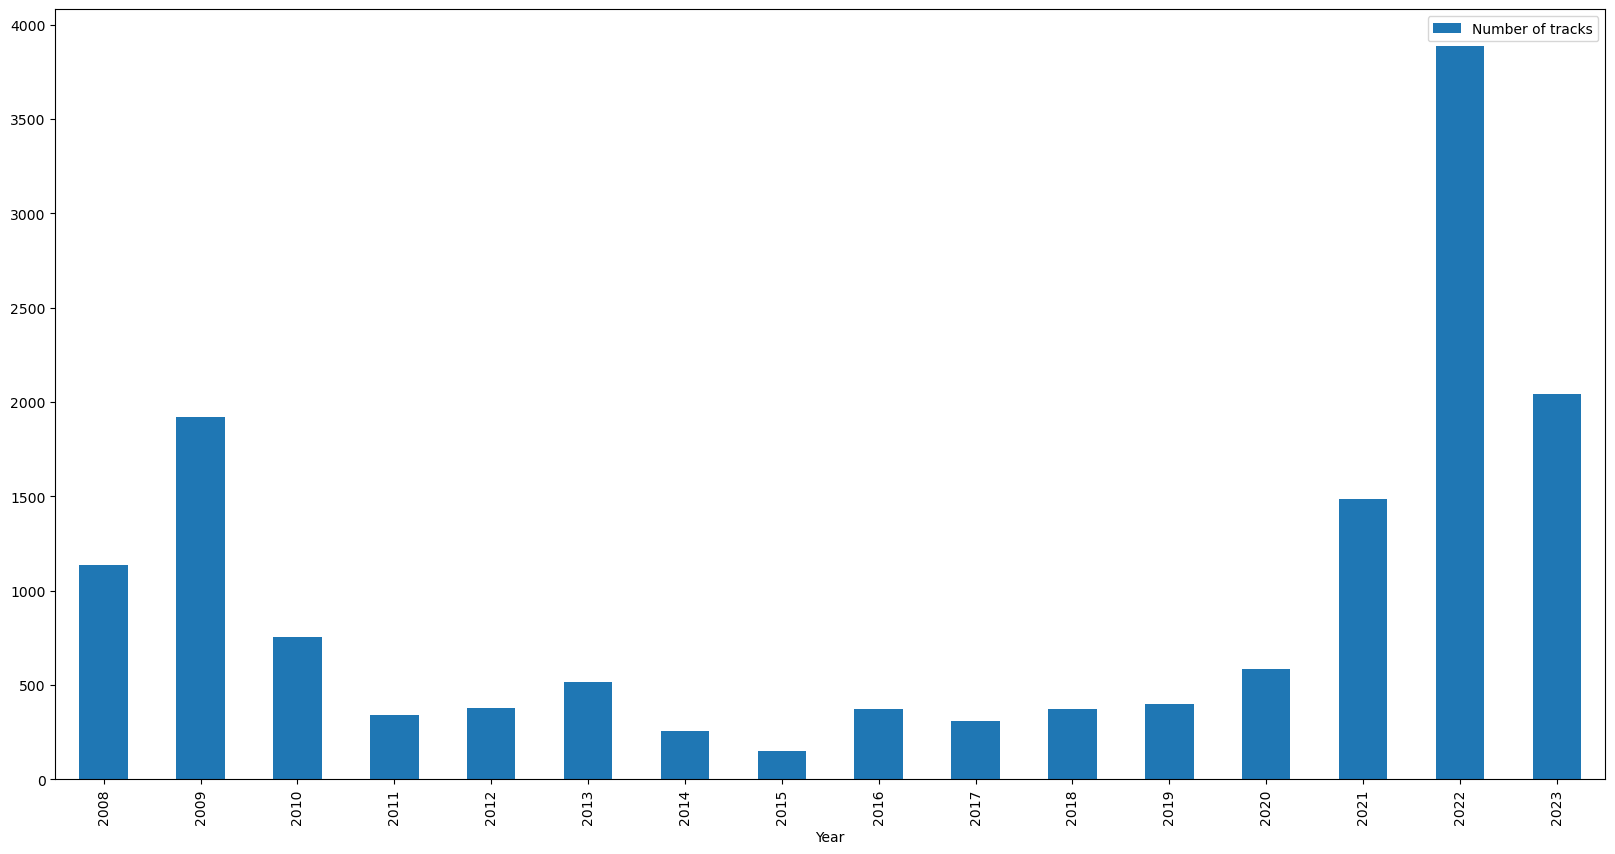

In [55]:
year_counts = {}

dates = lookup_json.dump(obj, ["*", "publishedAt"])
for date in dates:
    year = date.split(",")[0].split(" ")[-1]
    if year in year_counts:
        year_counts[year] += 1
    else:
        year_counts[year] = 1
        
year_items = list(sorted(year_counts.items(), key=lambda x: x[0], reverse=False))
df_year_counts = pd.DataFrame(year_items, columns=["Year", "Number of tracks"])
df_year_counts.describe()

df_year_counts.plot.bar(x="Year", y="Number of tracks", figsize=(20, 10))